In [1]:
import os
import numpy as np
import h5py
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [2]:
project_dir = "/Users/biratsapkota/PycharmProjects/PythonProject1"

train_file = os.path.join(project_dir, "sdr_train.hdf5")
test_file = os.path.join(project_dir, "sdr_test.hdf5")

# Load training data
with h5py.File(train_file, 'r') as f_train:
    X_train = f_train['X'][()]  # shape: (num_samples, buf, 2)
    y_train_raw = f_train['y'][()]

# Load test data
with h5py.File(test_file, 'r') as f_test:
    X_test = f_test['X'][()]
    y_test_raw = f_test['y'][()]

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (112464, 1024, 2)
Test data shape: (12497, 1024, 2)


In [3]:
# Convert 4-bit multi-hot labels to integers (0-15)
y_train = np.array([int("".join(map(str, label)), 2) for label in y_train_raw])
y_test = np.array([int("".join(map(str, label)), 2) for label in y_test_raw])

print("Converted training labels shape:", y_train.shape)
print("Converted test labels shape:", y_test.shape)


Converted training labels shape: (112464,)
Converted test labels shape: (12497,)


In [4]:
def extract_features(X):
    features = []
    for sample in X:
        I = sample[:,0]
        Q = sample[:,1]
        mag = np.sqrt(I**2 + Q**2)
        feat = [
            np.mean(I), np.std(I), np.min(I), np.max(I),
            np.mean(Q), np.std(Q), np.min(Q), np.max(Q),
            np.mean(mag), np.std(mag), np.min(mag), np.max(mag)
        ]
        features.append(feat)
    return np.array(features)

X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)

print("Feature shape:", X_train_features.shape)


Feature shape: (112464, 12)


In [5]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_features, y_train)
print("Random Forest training complete.")


Random Forest training complete.


In [6]:
y_pred_rf = rf_model.predict(X_test_features)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Test Accuracy:", accuracy_rf)
print("\nRandom Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))


Random Forest Test Accuracy: 0.8434024165799792

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       818
           1       0.94      0.96      0.95       784
           2       0.78      0.79      0.79       765
           3       0.80      0.76      0.78       789
           4       0.86      0.89      0.88       787
           5       0.82      0.83      0.82       814
           6       0.73      0.86      0.79       782
           7       0.76      0.79      0.77       775
           8       0.98      0.99      0.98       761
           9       0.98      0.96      0.97       802
          10       0.75      0.68      0.72       791
          11       0.83      0.86      0.84       772
          12       0.80      0.81      0.81       757
          13       0.80      0.86      0.83       784
          14       0.83      0.65      0.73       743
          15       0.85      0.80      0.83     

In [9]:
svm_model = SVC(
    kernel='rbf',  # RBF kernel
    C=10,
    gamma='scale',
    verbose=True
)
svm_model.fit(X_train_features, y_train)
print("SVM training complete.")


[LibSVM]...
*.
*
optimization finished, #iter = 3281
obj = -57240.467416, rho = -3.902722
nSV = 5818, nBSV = 5818
..
*
optimization finished, #iter = 2841
obj = -41141.900917, rho = -3.307402
nSV = 5594, nBSV = 5594
..
*
optimization finished, #iter = 2580
obj = -31958.324261, rho = -3.069088
nSV = 5072, nBSV = 5072
..
*
optimization finished, #iter = 2869
obj = -51228.197761, rho = -3.685366
nSV = 5722, nBSV = 5722
...
*
optimization finished, #iter = 3083
obj = -42904.574834, rho = -3.293169
nSV = 5812, nBSV = 5810
..
*.
*
optimization finished, #iter = 2483
obj = -34118.812920, rho = -2.950614
nSV = 4912, nBSV = 4912
..
*
optimization finished, #iter = 2040
obj = -25216.373636, rho = -2.850139
nSV = 4028, nBSV = 4026
..
*.
*.
*
optimization finished, #iter = 3192
obj = -50311.690902, rho = -3.453978
nSV = 5748, nBSV = 5748
...
*.
*
optimization finished, #iter = 3062
obj = -47173.101089, rho = -3.187045
nSV = 5666, nBSV = 5666
.
*
optimization finished, #iter = 1918
obj = -23563.302

In [11]:
y_pred_svm = svm_model.predict(X_test_features)

<Figure size 1000x800 with 0 Axes>

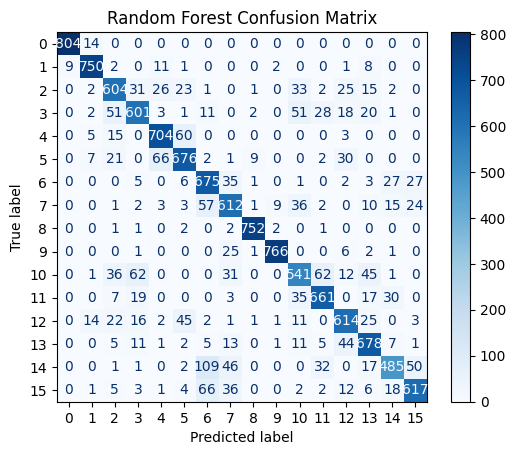

<Figure size 1000x800 with 0 Axes>

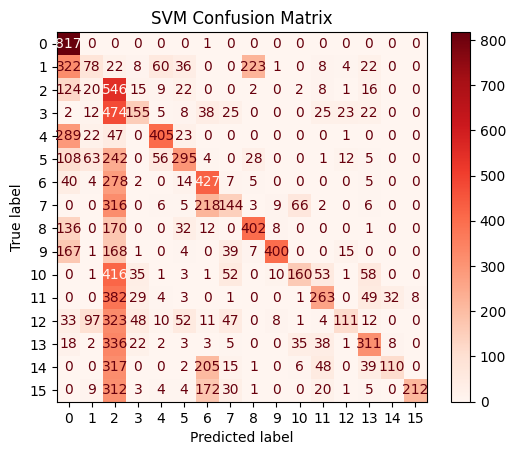

In [12]:
# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(cm_rf, display_labels=np.arange(16))

plt.figure(figsize=(10,8))
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()

# SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(cm_svm, display_labels=np.arange(16))

plt.figure(figsize=(10,8))
disp_svm.plot(cmap=plt.cm.Reds)
plt.title("SVM Confusion Matrix")
plt.show()


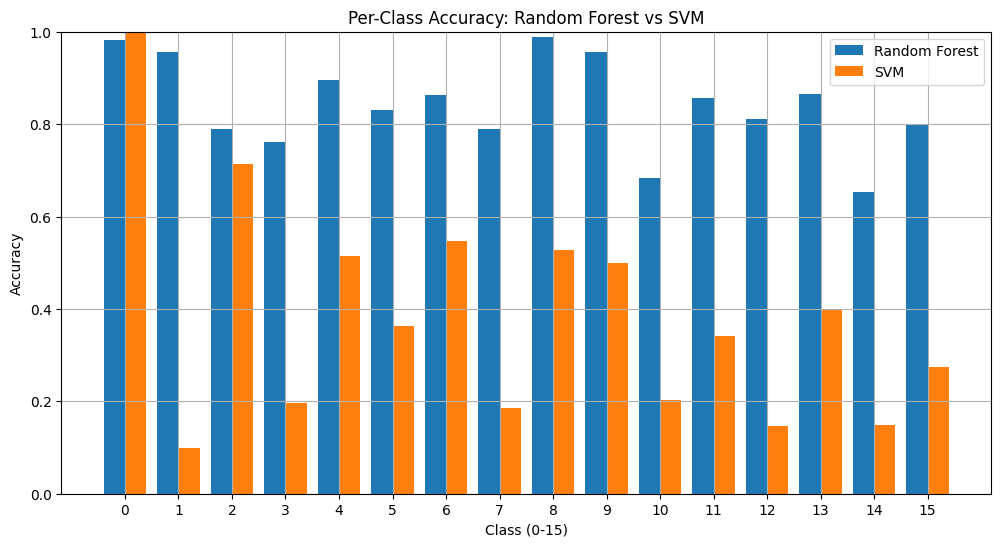

In [13]:
# Per-class accuracy
rf_class_acc = cm_rf.diagonal() / cm_rf.sum(axis=1)
svm_class_acc = cm_svm.diagonal() / cm_svm.sum(axis=1)

plt.figure(figsize=(12,6))
plt.bar(np.arange(16)-0.2, rf_class_acc, width=0.4, label="Random Forest")
plt.bar(np.arange(16)+0.2, svm_class_acc, width=0.4, label="SVM")
plt.xlabel("Class (0-15)")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy: Random Forest vs SVM")
plt.xticks(np.arange(16))
plt.ylim([0,1])
plt.grid(True)
plt.legend()
plt.show()


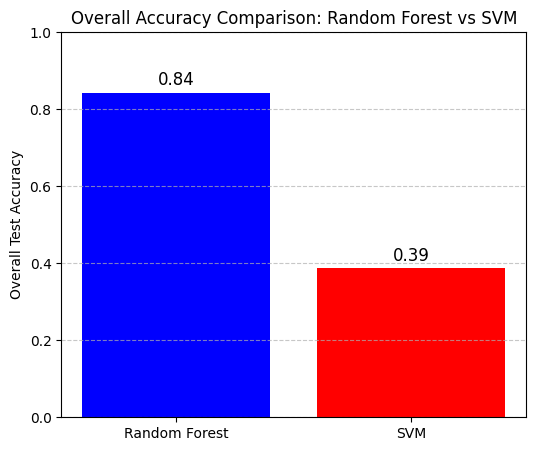

In [18]:
models = ['Random Forest', 'SVM']
accuracies = [accuracy_rf, accuracy_svm]

plt.figure(figsize=(6,5))
plt.bar(models, accuracies, color=['blue', 'red'])
plt.ylim([0, 1])
plt.ylabel('Overall Test Accuracy')
plt.title('Overall Accuracy Comparison: Random Forest vs SVM')

# Show exact accuracy values on top of bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()